<h1>Trying XGBoost and SHAP to Prepare for Super Computer</h1>

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from warnings import filterwarnings
import pickle
from tqdm.auto import tqdm
import json

from jeffutils.utils import movecol
from jeffutils import utils

filterwarnings('ignore')
pd.set_option('display.max_columns', None)

<h3>Read in the data from <code>.feather</code></h3>

In [2]:
# Read in the data
df = pd.read_feather('data/dylan_data/play_by_play_full_state_space.feather')
df = df.loc[:, ~df.columns.str.contains('_raw')]
df.head()

,game_date,date_time,game_id,home_name,away_name,event_type,penalty_severity,penalty_minutes,event_team,event_team_type,period_type,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,home_final,away_final,strength_state,strength_code,strength,empty_net,extra_attacker,home_skaters,away_skaters,order,STATE_BLOCKED_SHOT_AWAY,STATE_BLOCKED_SHOT_HOME,STATE_FACEOFF_AWAY,STATE_FACEOFF_HOME,STATE_GIVEAWAY_AWAY,STATE_GIVEAWAY_HOME,STATE_GOAL_AWAY,STATE_GOAL_HOME,STATE_MISSED_SHOT_AWAY,STATE_MISSED_SHOT_HOME,STATE_PENALTY_AWAY,STATE_PENALTY_HOME,STATE_SHOT_AWAY,STATE_SHOT_HOME,STATE_TAKEAWAY_AWAY,STATE_TAKEAWAY_HOME
0,2010-10-07,2010-10-07T23:29:40Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,FACEOFF_AWAY,-,0.0,Montréal Canadiens,away,REGULAR,1,0,1200.0,0,3600,0,0,3.0,2.0,5v5,EV,Even,-,False,5,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2010-10-07,2010-10-07T23:30:52Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,GIVEAWAY_HOME,-,0.0,Toronto Maple Leafs,home,REGULAR,1,69,1131.0,69,3531,0,0,3.0,2.0,5v5,EV,Even,-,False,5,5,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2010-10-07,2010-10-07T23:30:56Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,BLOCKED_SHOT_AWAY,-,0.0,Montréal Canadiens,away,REGULAR,1,73,1127.0,73,3527,0,0,3.0,2.0,5v5,EV,Even,-,False,5,5,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,2010-10-07,2010-10-07T23:31:09Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,SHOT_AWAY,-,0.0,Montréal Canadiens,away,REGULAR,1,86,1114.0,86,3514,0,0,3.0,2.0,5v5,EV,Even,-,False,5,5,3,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2010-10-07,2010-10-07T23:31:14Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,SHOT_AWAY,-,0.0,Montréal Canadiens,away,REGULAR,1,91,1109.0,91,3509,0,0,3.0,2.0,5v5,EV,Even,-,False,5,5,4,1,0,1,0,0,1,0,0,0,0,0,0,2,0,0,0


<h3>Get Last Two Seasons from Data</h3>

In [1]:
# Get only the rows with game_date >= 2021-10-01
df_last_two = df[df['game_date'] >= '2021-10-01']

# Create win column
df_last_two['win'] = (df_last_two['home_final'] > df_last_two['away_final']).astype(int)

# Drop columns we do not need for XGBoost
df_last_two.drop(columns=['game_date', 'date_time', 'game_id', 'home_name', 'away_name',
                          'event_type', 'penalty_severity', 'penalty_minutes', 'event_team',
                          'event_team_type', 'period_type', 'period', 'period_seconds',
                          'period_seconds_remaining', 'game_seconds', 'home_final', 'away_final',
                          'strength_state', 'strength', 'empty_net',
                          'extra_attacker', 'home_skaters', 'away_skaters', 'order',
                          ], inplace=True)

# One hot encode stregnth_code
df_last_two = pd.get_dummies(df_last_two, columns=['strength_code'], drop_first=True)

# Get the X and y
X = df_last_two.drop(columns=['win'])
y = df_last_two['win']

NameError: name 'df' is not defined

<h1>Creating Code for XGBoost</h1>

<h3>Read in Data, Fix Naming Errors, Get Last Two Seasons, and Drop Unnecessary Columns</h3>

In [3]:
# Read in the data
df = pd.read_feather('./data/dylan_data/play_by_play_full_state_space.feather')
df = df.loc[:, ~df.columns.str.contains('_raw')]

df['home_name'] = df['home_name'].replace({'Montréal Canadiens': 'Montreal Canadiens',
                                           'MontrÃ©al Canadiens': 'Montreal Canadiens'})
df['away_name'] = df['away_name'].replace({'Montréal Canadiens': 'Montreal Canadiens',
                                             'MontrÃ©al Canadiens': 'Montreal Canadiens'})

# Get only the rows with game_date >= 2021-10-01
df_last_two = df[df['game_date'] >= '2018-10-01']

df_train, df_test = df_last_two[df_last_two['game_date'] < '2023-10-01'], df_last_two[df_last_two['game_date'] >= '2023-10-01']

# Drop columns we do not need for XGBoost
drop_columns = ['game_date', 'date_time',
                          'event_type', 'penalty_severity', 'penalty_minutes', 'event_team',
                          'event_team_type', 'period_type', 'period', 'period_seconds',
                          'period_seconds_remaining',
                          'strength_state', 'strength', 'empty_net',
                          'extra_attacker', 'home_skaters', 'away_skaters', 'order',
                          ]

df_train.drop(columns=drop_columns, inplace=True)
df_test.drop(columns=drop_columns, inplace=True)

# Create win column
df_train['win'], df_test['win'] = (df_train['home_final'] > df_train['away_final']).astype(int), (df_test['home_final'] > df_test['away_final']).astype(int)
# df_last_two['win'] = (df_last_two['home_final'] > df_last_two['away_final']).astype(int)




# df_last_two.drop(columns=['game_date', 'date_time',
#                           'event_type', 'penalty_severity', 'penalty_minutes', 'event_team',
#                           'event_team_type', 'period_type', 'period', 'period_seconds',
#                           'period_seconds_remaining',
#                           'strength_state', 'strength', 'empty_net',
#                           'extra_attacker', 'home_skaters', 'away_skaters', 'order',
#                           ], inplace=True)

# df_last_two

In [4]:
def get_team_df(team_one, df_last_two):
    """
    Generates a DataFrame containing features relevant to team_one's performance 
    and interactions with opponents from previous two seasons.

    Args:
    - team_one (str): Name of the team for which the DataFrame is generated.
    - df_last_two (DataFrame): DataFrame containing data for the last two seasons.

    Returns:
    - DataFrame: A DataFrame with the following columns:
        - 'team': Name of the selected team.
        - 'is_home': Binary indicator if the selected team played at home (1) or away (0).
        - 'curr_strength_code': Current strength code of the selected team.
        - 'curr_goals': Number of goals scored by the selected team in the current match.
        - 'curr_opponent_goals': Number of goals scored by the opponent in the current match.
        - 'win': Binary indicator if the selected team won the current match (1) or not (0).
        - 'team_STATE': Features related to the selected team's performance in various states.
        - 'opponent_STATE': Features related to the opponent's performance in various states.
        - 'opp': Name of the opponent.
        - One-hot encoded columns for opponents and current strength codes.
    """
    
    # Get a subset of the data that just has team_one
    df_team_one = df_last_two[(df_last_two['home_name'] == team_one) | (df_last_two['away_name'] == team_one)]

    # Create a new column called 'opponent' that is the name of the team that team_one is playing
    df_team_one['opponent'] = np.where(df_team_one['home_name'] == team_one, df_team_one['away_name'], df_team_one['home_name'])

    # Create a new column if the selected team is the home team or not
    df_team_one['is_home'] = (df_team_one['home_name'] == team_one).astype(int)
    df_team_one['team'] = team_one

    # Get the scored goals for the selected team
    df_team_one['final_goals'] = np.where(df_team_one['home_name'] == team_one, df_team_one['home_final'], df_team_one['away_final'])

    # Get the scored goals for the opponent
    df_team_one['final_opponent_goals'] = np.where(df_team_one['home_name'] == team_one, df_team_one['away_final'], df_team_one['home_final'])

    # Get the current scored goals for the selected team and the opponent
    df_team_one['curr_goals'] = np.where(df_team_one['home_name'] == team_one, df_team_one['home_score'], df_team_one['away_score'])
    df_team_one['curr_opponent_goals'] = np.where(df_team_one['home_name'] == team_one, df_team_one['away_score'], df_team_one['home_score'])

    # Create home and away strength codes
    df_team_one['home_strength_code'] = df_team_one['strength_code']
    df_team_one['away_strength_code'] = 'EV'
    df_team_one.loc[df_team_one['home_strength_code'] == 'SH', 'away_strength_code'] = 'PP'
    df_team_one.loc[df_team_one['home_strength_code'] == 'PP', 'away_strength_code'] = 'SH'

    # Get the current strength code for the selected
    df_team_one['curr_strength_code'] = np.where(df_team_one['home_name'] == team_one, df_team_one['home_strength_code'], df_team_one['away_strength_code'])

    # Get if the selected team won or not
    # df_team_one.drop(columns=['home_final', 'away_final', win], inplace=True)
    df_team_one['win'] = (df_team_one['final_goals'] > df_team_one['final_opponent_goals']).astype(int)
    df_team_one = movecol(df_team_one, ['team', 'opponent', 'is_home', 'curr_strength_code', 'curr_goals', 'curr_opponent_goals', 'win'], 'strength_code', 'Before')

    # Drop a bunch of columns
    df_team_one.drop(columns=['home_score', 'away_score', 'home_final', 'away_final', 'home_name', 'away_name', 'strength_code',
                            'final_goals', 'final_opponent_goals', 'home_strength_code', 'away_strength_code'], inplace=True)

    # Get all columns with 'STATE_'
    state_columns_pre = df_team_one.columns[df_team_one.columns.str.contains('STATE_')]
    state_columns = list(set(["_".join(state.split('_')[:-1]) for state in state_columns_pre]))
    sorted(state_columns)

    # Iterate through each state getting the appropriate value for the selected team.
    for state in state_columns:
        df_team_one[f"team_{state}"] = np.where(df_team_one['is_home'] == 1, df_team_one[f'{state}_HOME'], df_team_one[f'{state}_AWAY'])

    # Iterate through each state getting the appropriate value for the opponent.
    for state in state_columns:
        df_team_one[f"opponent_{state}"] = np.where(df_team_one['is_home'] == 1, df_team_one[f'{state}_AWAY'], df_team_one[f'{state}_HOME'])    

    # Drop state_columns_pre
    df_team_one.drop(columns=state_columns_pre, inplace=True)

    # one hot opponent
    df_team_one['opp'] = df_team_one['opponent']
    df_team_one = pd.get_dummies(df_team_one, columns=['opponent'])

    # one hot strength_code
    df_team_one = pd.get_dummies(df_team_one, columns=['curr_strength_code'], drop_first=True)
    return df_team_one
    

In [36]:
def get_xgboost_and_pickle(team_one, df_train, df_test):
    """
    Trains an XGBoost classifier on data for team_one and saves the model as a pickle file.

    Args:
    - team_one (str): Name of the team for which the model is trained.
    - df_last_two (DataFrame): DataFrame containing data for the last two seasons.

    Returns:
    - None: The trained XGBoost model is saved as a pickle file.

    Note:
    This function internally calls the 'get_team_df' function to preprocess the data 
    before training the XGBoost model. The saved model is named after the team.
    """
    # Get the data.
    df_team_one_train = get_team_df(team_one, df_train)
    df_team_one_test = get_team_df(team_one, df_test)
    
    # Get X and y
    X_train = df_team_one_train.drop(columns=['game_id', 'team', 'win', 'opp'])
    y_train = df_team_one_train['win']

    X_test = df_team_one_test.drop(columns=['game_id', 'team', 'win', 'opp'])
    y_test = df_team_one_test['win']
    
    for col in X_train.columns:
        if col not in X_test.columns:
            X_test[col] = 0
    
    # Create a DMatrix
    # dtrain = xgb.DMatrix(X_train, y_train, feature_names=X.columns)
    # dtest = xgb.DMatrix(X_test, y_test, feature_names=X.columns)

    # Train the model
    params = params = {
        "eta": 0.05,
        "max_depth": 10,
        "tree_method": "hist",
        "lambda": 0.98,
        "eval_metric": "logloss",
        # "device": 'cuda'
    }
    model = XGBClassifier(**params).fit(X_train, y_train)
    
    # Test the model and save the data to a dictionary
    test_preds = model.predict(X_test)
    test_accuracy = np.mean(test_preds == y_test)

    # Pickle the model
    # Save the model weights as a pickle file
    with open(f'team_xgboost_files/{team_one}.pkl', 'wb') as f:
        pickle.dump(model, f)
    
    return test_accuracy


# Iterate through each team
pbar = tqdm(total=len(df_last_two['home_name'].unique()))
for team in df_last_two['home_name'].unique():
    if team == 'American All-Stars':
        continue
    res = get_xgboost_and_pickle(team, df_train, df_test)
    pbar.update(1)
    pbar.set_description(f'{team} - {res}')


  0%|          | 0/33 [00:00<?, ?it/s]

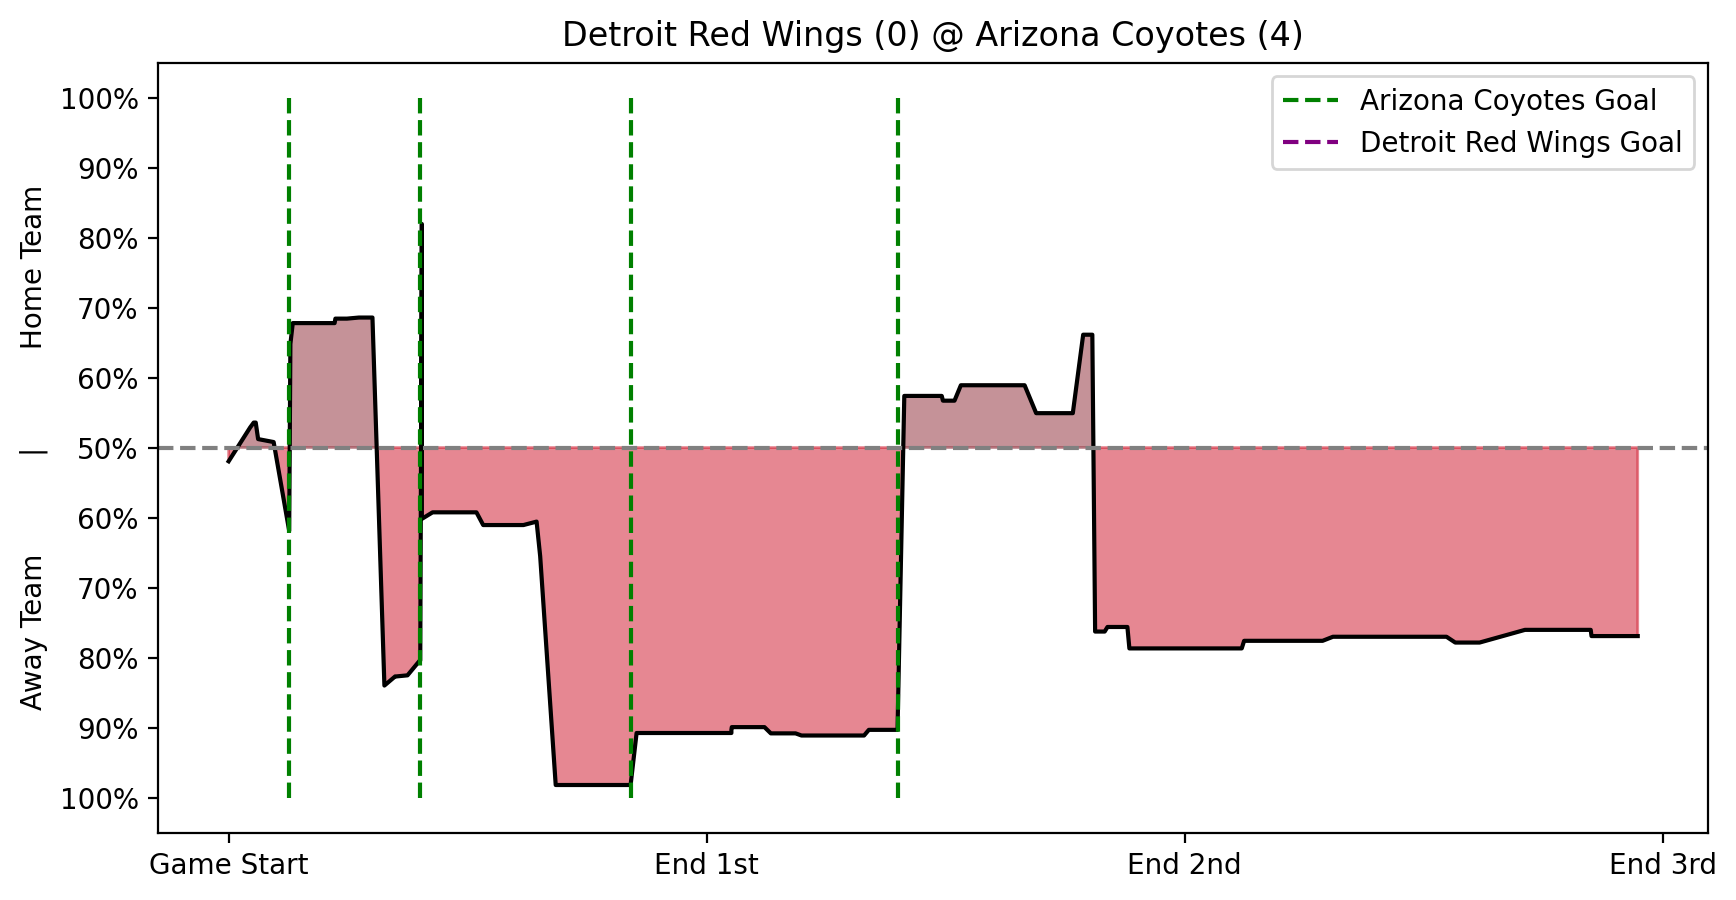

In [33]:
def predict_game_xgboost(team, df_train, df_test, animate=False):
    """
    Predicts the win probability of a game for a given team using an XGBoost classifier 
    and visualizes the probabilities along with goal events.

    Args:
    - team (str): Name of the team for which the game prediction is made.
    - df (DataFrame): DataFrame containing data for the matches.

    Returns:
    - tuple: A tuple containing:
        - home_goals (array): Array of game seconds when the home team scores.
        - away_goals (array): Array of game seconds when the away team scores.
        - game_data (DataFrame): DataFrame containing data for the predicted game.

    Note:
    This function reads team colors from 'team_colors.json', loads the XGBoost model 
    trained for the specified team, predicts the win probability for a randomly selected 
    game, and plots the probability along with goal events. The plot displays the 
    probabilities, goal events, and periods of the game.
    """
    
    # Read in team colors
    with open('team_colors.json') as f:
        team_colors = json.load(f)

    # Load the model
    with open(f'team_xgboost_files/{team}.pkl', 'rb') as f:
        model = pickle.load(f)
        
    # Get the data.
    df_team_one_train = get_team_df(team, df_train)
    df_team_one_test = get_team_df(team, df_test)
    
    # Get a unique game id
    game_id = np.random.choice(df_team_one_test['game_id'].unique())

    # Get the game data
    game_data = df_team_one_test[df_team_one_test['game_id'] == game_id]
    team, opp = game_data['team'].values[0], game_data['opp'].values[0]

    # Get who the home team is
    home_team = team if game_data['is_home'].values[0] == 1 else opp
    away_team = opp if game_data['is_home'].values[0] == 1 else team

    # Get colors for home and away team
    home_color = team_colors[home_team]
    away_color = team_colors[away_team]
    
    # Get X and y
    X_train = df_team_one_train.drop(columns=['game_id', 'team', 'win', 'opp'])
    y_train = df_team_one_train['win']

    X = game_data.drop(columns=['game_id', 'team', 'win', 'opp'])
    y_test = game_data['win']
    
    for col in X_train.columns:
        if col not in X.columns:
            X[col] = 0

    # Predict the win probability
    y_pred = model.predict_proba(X)

    # Plot the probability of the second team winning
    time_vals = game_data.game_seconds
    pred_vals = y_pred[:, 1] if home_team == team else y_pred[:, 0]

    # Set threshold
    threshold = 0.5
    
    if animate:
        fig, ax = plt.subplots(figsize=(10, 5), dpi=200)

        def animate(frame):
            ax.clear()

            # Plot the probabilities
            ax.plot(time_vals[:frame], pred_vals[:frame], color='black')

            home_where = pred_vals[:frame] >= threshold if home_team == team else pred_vals[:frame] < threshold
            away_where = pred_vals[:frame] < threshold if home_team == team else pred_vals[:frame] >= threshold

            # Fill area above 50% with blue for Home Team
            ax.fill_between(time_vals[:frame], threshold, pred_vals[:frame], where=home_where, color=home_color['main'], interpolate=True, alpha=0.5)

            # Fill area below 50% with red for Home Team
            ax.fill_between(time_vals[:frame], threshold, pred_vals[:frame], where=away_where, color=away_color['main'], interpolate=True, alpha=0.5)

            # Add a dotted horizontal line at y = 0.5
            ax.axhline(y=0.5, color='gray', linestyle='--')
            ax.set_yticks([0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
            ax.set_yticklabels(['100%', '90%', '80%', '70%', '60%', '50%', '60%', '70%', '80%', '90%', '100%'])

            # Plot when the goal was scored
            mask = (game_data.curr_goals.shift(-1) != game_data.curr_goals).values
            mask[-1] = False
            opp_mask = (game_data.curr_opponent_goals.shift(-1) != game_data.curr_opponent_goals).values
            opp_mask[-1] = False
            team_goals = game_data[mask]['game_seconds']
            opp_goals = game_data[opp_mask]['game_seconds']
            home_goals = team_goals if home_team == team else opp_goals
            away_goals = team_goals if home_team == opp else opp_goals
            ax.vlines(home_goals, 0, 1, color='green', linestyle='--', label=f'{home_team} Goal')
            ax.vlines(away_goals, 0, 1, color='purple', linestyle='--', label=f'{away_team} Goal')

            # Plot periods
            ax.set_xticks([0, 1200, 2400, 3600])
            ax.set_xticklabels(['Game Start', 'End 1st', 'End 2nd', 'End 3rd'])
            ax.set_title(f'{away_team} ({len(away_goals)}) @ {home_team} ({len(home_goals)})')
            ax.set_ylabel(f'Away Team           |           Home Team')
            ax.legend()

        # Create the animation
        ani = animation.FuncAnimation(fig, animate, frames=len(time_vals), interval=100)
        
    
    
    if not animate:
        # Plot the probabilities
        plt.figure(figsize=(10, 5), dpi=200)
        plt.plot(time_vals, pred_vals, color='black')

        home_where = pred_vals >= threshold if home_team == team else pred_vals < threshold
        away_where = pred_vals < threshold if home_team == team else pred_vals >= threshold

        # Fill area above 50% with blue for Home Team
        plt.fill_between(time_vals, threshold, pred_vals, where=pred_vals >= threshold, color=home_color['main'], interpolate=True, alpha=0.5)

        # Fill area below 50% with red for Home Team
        plt.fill_between(time_vals, threshold, pred_vals, where=pred_vals < threshold, color=away_color['main'], interpolate=True, alpha=0.5)

        # Add a dotted horizontal line at y = 0.5
        plt.axhline(y=0.5, color='gray', linestyle='--')
        plt.yticks(ticks=[0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0], labels=['100%', '90%', '80%', '70%', '60%', '50%', '60%', '70%', '80%', '90%', '100%'])

        # Plot when the goal was scored
        mask = (game_data.curr_goals.shift(-1) != game_data.curr_goals).values
        mask[-1] = False
        opp_mask = (game_data.curr_opponent_goals.shift(-1) != game_data.curr_opponent_goals).values
        opp_mask[-1] = False
        team_goals = game_data[mask]['game_seconds']
        opp_goals = game_data[opp_mask]['game_seconds']
        home_goals = team_goals if home_team == team else opp_goals
        away_goals = team_goals if home_team == opp else opp_goals
        plt.vlines(home_goals, 0, 1, color='green', linestyle='--', label=f'{home_team} Goal')
        plt.vlines(away_goals, 0, 1, color='purple', linestyle='--', label=f'{away_team} Goal')

        # Plot periods
        # plt.vlines([1200, 2400, 3600], 0, 1, color='black', linestyle='-', label='Period End')
        plt.xticks(ticks=[0, 1200, 2400, 3600], labels=['Game Start', 'End 1st', 'End 2nd', 'End 3rd'])
        plt.title(f'{away_team} ({len(away_goals)}) @ {home_team} ({len(home_goals)})')
        plt.ylabel(f'Away Team           |           Home Team')
        plt.legend()

    # Show plot
    plt.show()
    
    # Plot when the goal was scored
    mask = (game_data.curr_goals.shift(-1) != game_data.curr_goals).values
    mask[-1] = False
    opp_mask = (game_data.curr_opponent_goals.shift(-1) != game_data.curr_opponent_goals).values
    opp_mask[-1] = False
    team_goals = game_data[mask]['game_seconds']
    opp_goals = game_data[opp_mask]['game_seconds']
    home_goals = team_goals if home_team == team else opp_goals
    away_goals = team_goals if home_team == opp else opp_goals
    
    return home_goals, away_goals, game_data

    
# Predict the game
random_team = np.random.choice(df_test['home_name'].unique())
hg, ag, df = predict_game_xgboost(random_team, df_train, df_test, animate=False)

<h1>Simulating Games for Accuracy Metric</h1>

To simulate games for accuracy metric, we will randomly selected 100 games, simulate those games 100 times, and calculate the how often we correctly predict the game.

In [84]:
def accuracy_check_xgboost(df, df_test, game_ids=None):
    """
    Checks the accuracy of randomly selected XGBoost models for predicting game outcomes.

    Args:
    - df (DataFrame): DataFrame containing data for the matches.

    Returns:
    - float: Mean accuracy of the XGBoost models over 100 iterations.

    Note:
    This function randomly selects a game and a team from the DataFrame, loads the 
    corresponding XGBoost model, and evaluates its accuracy by predicting game outcomes 
    on a subset of randomly selected data. The process is repeated 100 times, and the 
    mean accuracy of the models is returned.
    """
    
    # If game_ids is None, get all the game_ids
    if game_ids is None:
        acc_list = []
        pbar = tqdm(total=100)
        for i in range(100):
            # Select a random game
            game_id = np.random.choice(df['game_id'].unique())
            
            # Select a random team's model to use from that game
            team = np.random.choice([df[df['game_id'] == game_id]['home_name'].unique()[0], df[df['game_id'] == game_id]['away_name'].unique()[0]])
            
            # Load the model
            with open(f'team_xgboost_files/{team}.pkl', 'rb') as f:
                model = pickle.load(f)
            
            # Get the subset of the data for the selected team
            df_team_one = get_team_df(team, df)
            
            # Get 10k random rows from the data
            rows = np.random.choice(df_team_one.index, 10000)
            df_team_one = df_team_one.loc[rows, :]
            
            # Get the X and y
            X = df_team_one.drop(columns=['game_id', 'team', 'win', 'opp'])
            y = df_team_one['win']
            
            # Predict the win probability
            y_pred = model.predict(X)
            acc_list.append(np.mean(y_pred == y))
            
            # Update pbar
            pbar.update(1)
            pbar.set_description(f'Current accuracy: {np.mean(acc_list)}')
        return np.mean(acc_list)

    # If game_ids is not None, get the accuracy for those game_ids
    acc_list = []
    return_df = None
    pbar = tqdm(total=len(game_ids))
    for game_id in game_ids:
        # Select a random team's model to use from that game
        team = df_test[df_test['game_id'] == game_id]['home_name'].unique()[0]
        
        # Get the data.
        X_train = get_team_df(team, df)
        X_test = get_team_df(team, df_test)
        
        
        for col in X_train.columns:
            if col not in X_test.columns:
                X_test[col] = 0
        
        # Load the model
        with open(f'team_xgboost_files/{team}.pkl', 'rb') as f:
            model = pickle.load(f)

        # Get the subset of the data for the selected team (and game_id)
        df_team_one = X_test[X_test['game_id'] == game_id]
        
        # Get the X and y
        X = df_team_one.drop(columns=['game_id', 'team', 'win', 'opp'])
        y = df_team_one['win']

        # Predict the win probability
        y_pred = model.predict_proba(X)
        acc_list.append(np.mean(np.argmax(y_pred[:, 1]) == y))
        
        # Update return_df
        if return_df is None:
            return_df = pd.DataFrame({'game_id': game_id, 'game_seconds': df_team_one['game_seconds'], 'probability_home': y_pred[:, 1]})
        else:
            return_df = pd.concat([return_df, pd.DataFrame({'game_id': game_id, 'game_seconds': df_team_one['game_seconds'], 'probability_home': y_pred[:, 1]})])

        # Update pbar
        pbar.update(1)
        pbar.set_description(f'Current accuracy: {np.mean(acc_list)}')
    
    return return_df
    
game_ids = [2023020750, 2023020766, 2023020368, 2023020639, 2023020692, 2023020771, 2023020970, 2023020527, 2023020960, 2023020546, 2023020725, 2023020801, 2023020666, 2023020441, 2023020285, 2023020382, 2023020236, 2023020890, 2023020929, 2023020858, 2023020415, 2023020227, 2023020780, 2023020308, 2023020605, 2023020743, 2023020641, 2023020895, 2023020637, 2023020137, 2023020617, 2023020430, 2023020842, 2023020025, 2023020173, 2023020101, 2023020119, 2023020968, 2023020816, 2023020700, 2023020428, 2023021065, 2023020787, 2023020534, 2023020959, 2023020250, 2023020166, 2023020812, 2023020835, 2023020161, 2023020231, 2023020782, 2023020628, 2023020472, 2023020973, 2023020621, 2023020905, 2023020228, 2023020656, 2023020184, 2023020219, 2023020160, 2023020949, 2023020305, 2023020875, 2023020283, 2023020862, 2023020675, 2023020293, 2023020714, 2023020446, 2023021044, 2023020784, 2023020811, 2023020796, 2023020578, 2023020095, 2023021004, 2023020789, 2023020682, 2023020663, 2023020730, 2023020181, 2023020561, 2023020182, 2023020077, 2023020722, 2023020053, 2023020622, 2023020723, 2023020786, 2023020855, 2023020201, 2023020115, 2023020793, 2023020614, 2023020284, 2023020865, 2023020822, 2023020956]
results_df = accuracy_check_xgboost(df_train, df_test, game_ids=game_ids)
results_df.reset_index(drop=True, inplace=True)
results_df.to_feather('data/dylan_data/xgboost_results_df.feather')

  0%|          | 0/100 [00:00<?, ?it/s]